In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from tacrypto import talibCrypto

import time

In [2]:
from sklearn.metrics import precision_score, accuracy_score

In [3]:
# minute_data_cols = ['open', 'high', 'low', 'close', 'volume', 'time']
# binance_swap_min_BTCUSDT = pd.read_csv('binance_swap_kline.BTCUSDT.csv')
# binance_swap_min_BTCUSDT['t'] = pd.to_datetime(binance_swap_min_BTCUSDT['t'], unit='ms')
# binance_swap_min_BTCUSDT.columns = minute_data_cols
# binance_swap_min_BTCUSDT.set_index('time', inplace=True)

# binance_swap_min_BTCUSDT = binance_swap_min_BTCUSDT.loc["2019-09-09 02:51:00":]

# binance_swap_min_BTCUSDT = binance_swap_min_BTCUSDT.groupby(binance_swap_min_BTCUSDT.index).last()

# binance_swap_min_BTCUSDT['vwap'] = (binance_swap_min_BTCUSDT['close'] + binance_swap_min_BTCUSDT['high'] + binance_swap_min_BTCUSDT['low']) / 3
binance_swap_min_BTCUSDT = pd.read_csv('binance_swap_kline.BTCUSDT.from_trade.csv', index_col=0)
binance_swap_min_BTCUSDT = binance_swap_min_BTCUSDT.dropna()

In [4]:
binance_swap_min_BTCUSDT['vwap'] = (binance_swap_min_BTCUSDT['turnover'] / binance_swap_min_BTCUSDT['volume']).round(3)

In [5]:
tacry = talibCrypto(binance_swap_min_BTCUSDT)

In [6]:
start = time.time()
taSeriesList = []
for i in range(len(tacry.talib_function)):
    taSeriesList.append(tacry.talib_function[i]())
end = time.time()
print("Runtime: {}".format(end - start))

Runtime: 1.3193321228027344


In [7]:
interval= 5
return_pd_series = binance_swap_min_BTCUSDT['vwap'].pct_change(periods=interval).shift(-interval)
return_pd_series.name = '{}min_return'.format(interval)

In [8]:
taSeriesList.append(return_pd_series)

In [9]:
ta_df = pd.concat(taSeriesList, axis=1).astype('float32')

In [10]:
ta_df.dropna(inplace=True)

In [11]:
ta_df['label'] = ta_df['{}min_return'.format(interval)]

In [12]:
ta_df.index = pd.DatetimeIndex(ta_df.index)

In [13]:
ta_df.to_csv('test.csv')

In [14]:
ta_train_df = ta_df.loc["2019-09-20":"2020-10-05"]
ta_val_df = ta_df.loc["2020-10-06":"2020-11-06"]
ta_test_df = ta_df.loc["2020-11-06":]

feature_num = len(tacry.talib_function)
print(feature_num)

train_X = ta_train_df.iloc[:, :feature_num].values
train_Y = ta_train_df['label'].values

val_X = ta_val_df.iloc[:, :feature_num].values
val_Y = ta_val_df['label'].values

test_X = ta_test_df.iloc[:, :feature_num].values
test_Y = ta_test_df['label'].values

43


In [15]:
print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(549654, 43)
(549654,)
(46097, 43)
(46097,)
(60037, 43)
(60037,)


In [16]:
import xgboost as xgb

In [17]:
def huber_approx_obj(preds, dtrain):
    d = preds - dtrain.get_label()
    h = 1  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

In [18]:
Dtrain = xgb.DMatrix(data=train_X, label=train_Y)
Dval = xgb.DMatrix(data=val_X, label=val_Y)
Dtest = xgb.DMatrix(data=test_X, label=test_Y)

In [20]:
params = {
    'booster': 'gbtree',
    'eta': 0.3,
    'gamma': 0,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'lambda': 40,
    'alpha': 10,
    'tree_method': 'hist',
#     "objective": "reg:squarederror", 
    'eval_metric': ['mae'],
    'seed': 0
}

evals = {}
booster = xgb.train(
    params=params, 
    dtrain=Dtrain, evals=[(Dtrain, 'Train'), (Dval, 'Valid')],
    num_boost_round=100,
    verbose_eval=False,
    early_stopping_rounds=10,
    evals_result=evals,
    obj=huber_approx_obj
)

print(evals['Valid']['mae'][-1])
print(booster.eval(Dtest))

0.000936
[0]	eval-mae:0.001441


In [36]:
# ta_df.corr().astype("float32").to_csv('corr.csv')

In [21]:
val_pred_Y = booster.predict(Dval)
adjust_val_pred_Y = val_pred_Y

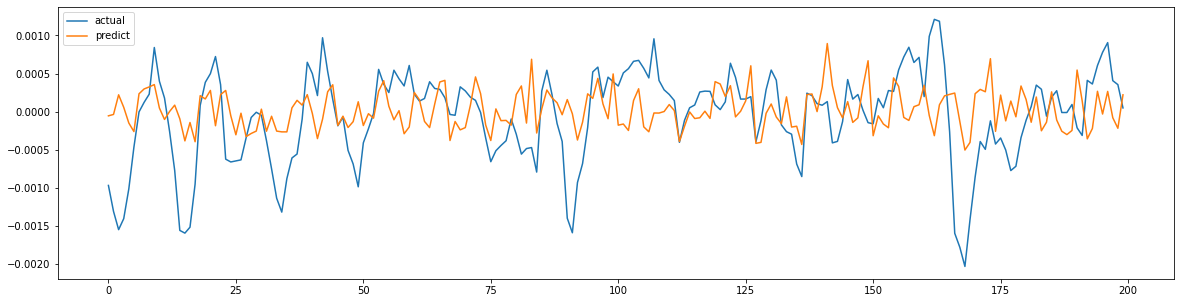

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(val_Y[:200], label='actual')
plt.plot(adjust_val_pred_Y[:200], label='predict')
plt.legend()

In [121]:
def action_transform(x):
    if x > 0.001:
        return 1
    elif x < -0.001:
        return -1
    else:
        return 0

In [122]:
val_true_action = list(map(action_transform, val_Y))
val_pred_action = list(map(action_transform, adjust_val_pred_Y))

In [123]:
(np.array(val_pred_action) == np.array(val_true_action)).sum() / len(val_true_action)

0.5362630208333333

In [124]:
actual_long = np.count_nonzero(np.array(val_true_action) == 1)
actual_short = np.count_nonzero(np.array(val_true_action) == -1)
actual_close = np.count_nonzero(np.array(val_true_action) == 0)

In [125]:
pred_long = 0
pred_short = 0
pred_close = 0
for i in range(len(val_true_action)):
    if val_true_action[i] == 1 and val_pred_action[i] == 1:
        pred_long += 1
    elif val_true_action[i] == -1 and val_pred_action[i] == -1:
        pred_short += 1
    elif val_true_action[i] == 0 and val_pred_action[i] == 0:
        pred_close += 1

print(pred_long / actual_long)
print(pred_short / actual_short)
print(pred_close / actual_close)

0.21455620208737416
0.16437935272429333
0.8153713366550277


### Classification

In [177]:
def action_transform(x):
    if x > 0.001:
        return 2
    elif x < -0.001:
        return 0
    else:
        return 1

In [178]:
ta_df['label'] = ta_df['{}min_return'.format(interval)].apply(action_transform)

In [179]:
ta_train_df = ta_df.loc["2019-09-09":"2020-10-05"]
ta_val_df = ta_df.loc["2020-10-06":"2020-11-06"]
ta_test_df = ta_df.loc["2020-11-06":]

feature_num = len(tacry.talib_function)
print(feature_num)

train_X = ta_train_df.iloc[:, :feature_num].values
train_Y = ta_train_df['label'].values

val_X = ta_val_df.iloc[:, :feature_num].values
val_Y = ta_val_df['label'].values

test_X = ta_test_df.iloc[:, :feature_num].values
test_Y = ta_test_df['label'].values

48


In [180]:
train_long = np.count_nonzero(np.array(train_Y) == 2)
train_short = np.count_nonzero(np.array(train_Y) == 0)
train_close = np.count_nonzero(np.array(train_Y) == 1)

In [181]:
len(train_Y)

565677

In [182]:
weight_for_2 = len(train_Y) / train_long * 0.33
weight_for_0 = len(train_Y) / train_short * 0.33
weight_for_1= len(train_Y) / train_close * 0.33
print(weight_for_2)
print(weight_for_0)
print(weight_for_1)

1.3300563591022443
1.3572102339648981
0.6486558020744654


In [183]:
def getWeight(x):
    if x == 2:
        return weight_for_2
    elif x == 0:
        return  weight_for_0
    else:
        return weight_for_1

weights = list(map(getWeight, train_Y))

In [184]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_X)
val_features = scaler.transform(val_X)
test_features = scaler.transform(test_X)

Dtrain = xgb.DMatrix(data=train_features, label=train_Y, weight=weights)
Dval = xgb.DMatrix(data=val_features, label=val_Y)
Dtest = xgb.DMatrix(data=test_features, label=test_Y)

In [198]:
params = {
    'booster': 'gbtree',
    'eta': 0.3,
    'gamma': 0,
    'max_depth': 6,
    'min_child_weight': 8,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'lambda': 40,
    'alpha': 10,
    'tree_method': 'gpu_hist',
    'objective': 'multi:softmax',
    'num_class': 3,
    'seed': 0
}

evals = {}
booster = xgb.train(
    params=params, 
    dtrain=Dtrain, evals=[(Dtrain, 'Train'), (Dval, 'Valid')],
    num_boost_round=100,
    verbose_eval=False,
    early_stopping_rounds=10,
    evals_result=evals
)

accuracy_score(y_true=val_Y, y_pred=booster.predict(Dval))

0.5411024305555555

In [186]:
val_pred_Y = booster.predict(Dval)

In [187]:
actual_long = np.count_nonzero(np.array(val_Y) == 2)
actual_short = np.count_nonzero(np.array(val_Y) == 0)
actual_close = np.count_nonzero(np.array(val_Y) == 1)

In [188]:
pred_long = 0
pred_short = 0
pred_close = 0
for i in range(len(val_Y)):
    if val_Y[i] == 2 and val_pred_Y[i] == 2:
        pred_long += 1
    elif val_Y[i] == 0 and val_pred_Y[i] == 0:
        pred_short += 1
    elif val_Y[i] == 1 and val_pred_Y[i] == 1:
        pred_close += 1

print(pred_long / actual_long)
print(pred_short / actual_short)
print(pred_close / actual_close)

0.42338597949570517
0.4296394920114707
0.6067715485111225


In [189]:
accuracy_score(val_Y, val_pred_Y)

0.5261501736111112

In [190]:
test_pred_Y = booster.predict(Dtest)
actual_long = np.count_nonzero(np.array(test_Y) == 2)
actual_short = np.count_nonzero(np.array(test_Y) == 0)
actual_close = np.count_nonzero(np.array(test_Y) == 1)
pred_long = 0
pred_short = 0
pred_close = 0
for i in range(len(test_Y)):
    if test_Y[i] == 2 and test_pred_Y[i] == 2:
        pred_long += 1
    elif test_Y[i] == 0 and test_pred_Y[i] == 0:
        pred_short += 1
    elif test_Y[i] == 1 and test_pred_Y[i] == 1:
        pred_close += 1

print(pred_long / actual_long)
print(pred_short / actual_short)
print(pred_close / actual_close)

0.5507102084163016
0.594361334867664
0.07351778656126483


In [191]:
accuracy_score(test_Y, test_pred_Y)

0.4003850509626274